In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

from scipy.stats import zscore
from scipy.stats import skew
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [2]:
import pandas as pd

In [4]:
# Load dataset
df= pd.read_csv("diabetic_data.csv")

In [5]:
# Data head
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


### Dropping the columns

In [39]:
df.drop(['weight','payer_code','encounter_id', 'patient_nbr'],axis=1,inplace=True)

### Replacing the missing values

In [40]:
# Replace missing values in the race column with the most frequent value
df['race'] = df['race'].fillna(df['race'].mode()[0])

In [41]:
# Replace missing values in the 'medical_specialty' column with the mode of the column
df['medical_specialty'].replace('?', np.nan, inplace=True)
df['medical_specialty'] = df['medical_specialty'].fillna(df['medical_specialty'].mode()[0])

In [42]:
import re #regex!

# Define a function to clean the age column
def clean_age(age):
    age = str(age) # Convert to string
    age = re.sub('[^0-9\-]', '', age) # Remove any non-numeric characters
    age = age.split('-') # Split the string into a list of values
    age = [int(x) for x in age if x != ''] # Convert each value to an integer and remove any empty strings
    if len(age) == 1:
        return age[0]
    else:
        return sum(age)/2 # Return the average of the lower and upper bounds of the age group

# Apply the clean_age function to the age column
df['age'] = df['age'].apply(clean_age)

In [43]:
bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100', '100-110']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)


## Label Encoding

In [44]:
# Import label encoder
from sklearn import preprocessing

# label_encoder object knows
# how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'readmitted'.
df['readmitted']= label_encoder.fit_transform(df['readmitted'])

df['readmitted'].unique()


array([2, 1, 0])

In [45]:
# Encode labels in column 'race'.
df['race']= label_encoder.fit_transform(df['race'])

df['race'].unique()


array([3, 1, 0, 5, 2, 4])

In [83]:
# Encode labels in column 'gender'.
df['gender']= label_encoder.fit_transform(df['gender'])

df['gender'].unique()


array([0, 1, 2], dtype=int64)

In [47]:
# Encode labels in column 'medical_specialty'.
df['medical_specialty']= label_encoder.fit_transform(df['medical_specialty'])

df['medical_specialty'].unique()


array([37, 18, 11,  3, 62, 27, 12, 60, 19, 28, 47,  8, 51, 64, 22, 24, 33,
       15, 30, 61, 35,  9, 71, 49, 41, 20,  2, 53, 38, 50, 45, 13, 25, 40,
       66, 68, 67, 26, 65, 36, 43, 17,  1, 55,  0, 63, 39, 34,  6, 58, 69,
       29, 48, 59, 44, 14, 46, 23, 70, 52, 32,  7, 57, 56, 16, 31,  4, 42,
       21, 10,  5, 54])

In [48]:
# Encode labels in column 'metformin'.
df['metformin']= label_encoder.fit_transform(df['metformin'])

df['metformin'].unique()


array([1, 2, 3, 0])

### Feature Engg.

In [49]:
# Combine the diagnosis codes
for col in ['diag_1', 'diag_2', 'diag_3']:
    df[col] = df[col].replace('?', np.nan) # Replace '?' with NaN
    df[col] = pd.to_numeric(df[col], errors='coerce') # Convert the column to a numerical column
    df.loc[(df[col] >= 390) & (df[col] < 400), col] = 1 # Circulatory system
    df.loc[(df[col] >= 401) & (df[col] < 410), col] = 2 # Respiratory system
    df.loc[(df[col] >= 410) & (df[col] < 460) | (df[col] == 785), col] = 3 # Digestive system
    df.loc[(df[col] >= 460) & (df[col] < 520) | (df[col] == 786), col] = 4 # Musculoskeletal system
    df.loc[(df[col] >= 520) & (df[col] < 580) | (df[col] == 787), col] = 5 # Genitourinary system
    df.loc[(df[col] >= 580) & (df[col] < 630) | (df[col] == 788), col] = 6 # Neoplasms
    df.loc[(df[col] >= 800) & (df[col] < 1000), col] = 7 # Injury and poisoning
    df.loc[(df[col] >= 710) & (df[col] < 740), col] = 8 # Congenital anomalies
    df.loc[(df[col] >= 140) & (df[col] < 240), col] = 9 # Other
    df.loc[(df[col] >= 240) & (df[col] < 280), col] = 10 # Other
    df.loc[(df[col] >= 680) & (df[col] < 710) | (df[col] >= 782) & (df[col] < 784) | (df[col] >= 790) & (df[col] < 800) | (df[col] >= 240) & (df[col] < 250), col] = 11 # Other
    df[col] = df[col].astype('category') # Convert the column to a categorical column


### Outliers Detection

In [51]:
import pandas as pd

# Assuming you have a DataFrame named 'df' with columns of different data types

# Check outliers for integer and float columns
numeric_columns = df.select_dtypes(include=['int', 'float']).columns
for column in numeric_columns:
    values = df[column].values
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    without_OL = df[(df[column] > lower_bound) & (df[column] < upper_bound)]
    

# Check outliers for object/string columns (based on unique values)
object_columns = df.select_dtypes(include='object').columns
for column in object_columns:
    value_counts = df[column].value_counts()
    no_outliers = value_counts[value_counts > 2]

In [52]:
a=pd.DataFrame(no_outliers)
b=pd.DataFrame(without_OL)

In [53]:
df_n= pd.concat([b,a])
df_n.head()

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age_group
0,3.0,0.0,5.0,6.0,25.0,1.0,1.0,37.0,41.0,0.0,...,No,No,No,No,No,No,No,No,2.0,0-20
1,3.0,0.0,15.0,1.0,1.0,7.0,3.0,18.0,59.0,0.0,...,Up,No,No,No,No,No,Ch,Yes,1.0,0-20
2,1.0,0.0,25.0,1.0,1.0,7.0,2.0,18.0,11.0,5.0,...,No,No,No,No,No,No,No,Yes,2.0,20-30
3,3.0,1.0,35.0,1.0,1.0,7.0,2.0,18.0,44.0,1.0,...,Up,No,No,No,No,No,Ch,Yes,2.0,30-40
4,3.0,1.0,45.0,1.0,1.0,7.0,1.0,18.0,51.0,0.0,...,Steady,No,No,No,No,No,Ch,Yes,2.0,40-50


In [54]:
df_n.drop(df_n.tail(2).index,inplace=True) # drop last n rows

In [55]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import classification_report

## train test split

In [61]:
!pip install imbalanced-learn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [57]:
df_n.dropna() # drop last n rows

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age_group
1,3.0,0.0,15.0,1.0,1.0,7.0,3.0,18.0,59.0,0.0,...,Up,No,No,No,No,No,Ch,Yes,1.0,0-20
3,3.0,1.0,35.0,1.0,1.0,7.0,2.0,18.0,44.0,1.0,...,Up,No,No,No,No,No,Ch,Yes,2.0,30-40
4,3.0,1.0,45.0,1.0,1.0,7.0,1.0,18.0,51.0,0.0,...,Steady,No,No,No,No,No,Ch,Yes,2.0,40-50
5,3.0,1.0,55.0,2.0,1.0,2.0,3.0,18.0,31.0,6.0,...,Steady,No,No,No,No,No,No,Yes,1.0,50-60
7,3.0,1.0,75.0,1.0,1.0,7.0,5.0,18.0,73.0,0.0,...,No,No,No,No,No,No,No,Yes,1.0,70-80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1.0,1.0,75.0,1.0,3.0,7.0,3.0,18.0,51.0,0.0,...,Down,No,No,No,No,No,Ch,Yes,1.0,70-80
101762,1.0,0.0,85.0,1.0,4.0,5.0,5.0,18.0,33.0,3.0,...,Steady,No,No,No,No,No,No,Yes,2.0,80-90
101763,3.0,1.0,75.0,1.0,1.0,7.0,1.0,18.0,53.0,0.0,...,Down,No,No,No,No,No,Ch,Yes,2.0,70-80
101764,3.0,0.0,85.0,2.0,3.0,7.0,10.0,62.0,45.0,2.0,...,Up,No,No,No,No,No,Ch,Yes,2.0,80-90


In [58]:
!pip install imbalanced-learn
feature_cols = df_n.select_dtypes(include=['int', 'float']).columns

In [59]:
#split dataset in features and target variable

X = df_n[feature_cols] # Features
y = df_n.readmitted # Target variable

In [62]:
# Split dataset into training set and test set
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test
from imblearn.over_sampling import SMOTE

# Split dataset into features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the SMOTE oversampler
smote = SMOTE(random_state=42)

# Apply SMOTE only to the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train your model on the oversampled training data
model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)


In [63]:
accuracy

0.9687540162309047

In [84]:
X_train_resampled, X_test, y_train_resampled, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


## Decision Tree

criterion : optional (default=”gini”) or Choose attribute selection measure. This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

splitter : string, optional (default=”best”) or Split Strategy. This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

max_depth : int or None, optional (default=None) or Maximum Depth of a Tree. The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting (Source).

In [68]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [69]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
report_CT_ENT = classification_report(y_test, y_pred)
print("Classification report:\n", report_CT_ENT)


Accuracy: 1.0
Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2323
         1.0       1.00      1.00      1.00      7543
         2.0       1.00      1.00      1.00     11505

    accuracy                           1.00     21371
   macro avg       1.00      1.00      1.00     21371
weighted avg       1.00      1.00      1.00     21371



Model accuracy score with criterion entropy: 1.0000


[Text(0.6, 0.8333333333333334, 'X[16] <= 1.5\nentropy = 1.363\nsamples = 71236\nvalue = [7932, 24901, 38403]'),
 Text(0.4, 0.5, 'X[16] <= 0.5\nentropy = 0.798\nsamples = 32833\nvalue = [7932, 24901, 0]'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.0\nsamples = 7932\nvalue = [7932, 0, 0]'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.0\nsamples = 24901\nvalue = [0, 24901, 0]'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 38403\nvalue = [0, 0, 38403]')]

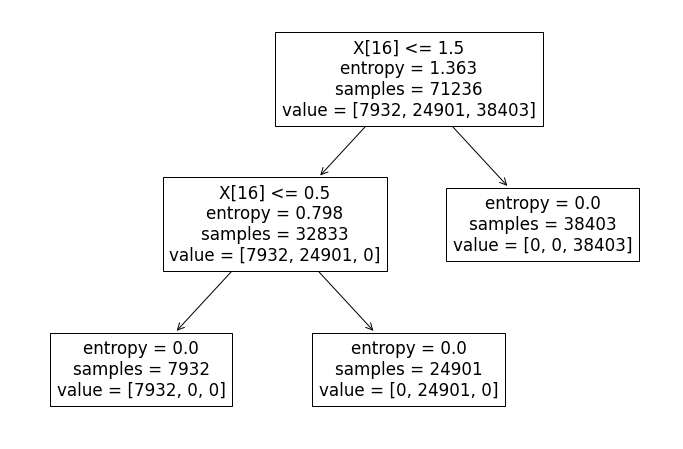

In [70]:
from sklearn.metrics import accuracy_score
print('Model accuracy score with criterion entropy: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train = clf.predict(X_train)
y_pred_train
plt.figure(figsize=(12,8))
from sklearn import tree
tree.plot_tree(clf.fit(X_train, y_train))

In [71]:
# Create Decision Tree classifer object
clf_gini = DecisionTreeClassifier(criterion="gini", max_depth=3)

# Train Decision Tree Classifer
clf_gini = clf_gini.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_gini.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
report_CT_G = classification_report(y_test, y_pred)
print("Classification report:\n", report_CT_G)


Accuracy: 1.0
Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2323
         1.0       1.00      1.00      1.00      7543
         2.0       1.00      1.00      1.00     11505

    accuracy                           1.00     21371
   macro avg       1.00      1.00      1.00     21371
weighted avg       1.00      1.00      1.00     21371



[Text(0.6, 0.8333333333333334, 'X[15] <= 1.5\ngini = 0.576\nsamples = 71236\nvalue = [8037, 24884, 38315]'),
 Text(0.4, 0.5, 'X[15] <= 0.5\ngini = 0.369\nsamples = 32921\nvalue = [8037, 24884, 0]'),
 Text(0.2, 0.16666666666666666, 'gini = 0.0\nsamples = 8037\nvalue = [8037, 0, 0]'),
 Text(0.6, 0.16666666666666666, 'gini = 0.0\nsamples = 24884\nvalue = [0, 24884, 0]'),
 Text(0.8, 0.5, 'gini = 0.0\nsamples = 38315\nvalue = [0, 0, 38315]')]

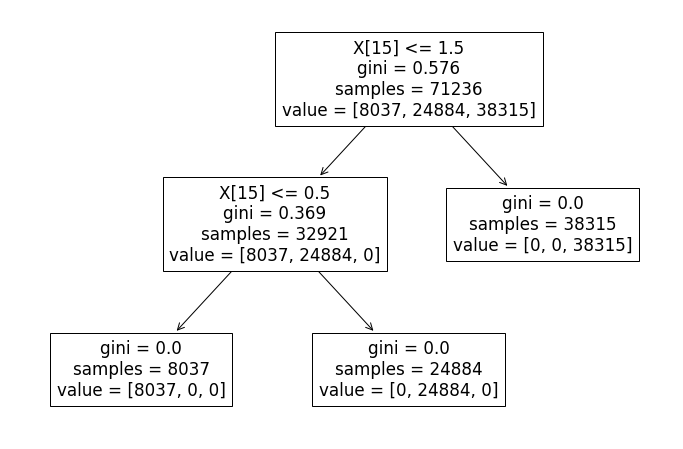

In [29]:
# Visualize decision tree
plt.figure(figsize=(12,8))
tree.plot_tree(clf_gini.fit(X_train, y_train))

## K-Nearest Neighbor

In [72]:
from sklearn.neighbors import KNeighborsClassifier

# Create a KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model on the training data
knn.fit(X_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = knn.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report_KNN = classification_report(y_test, y_pred)
print("Classification report:\n", report_KNN)

Accuracy: 0.7296336156473726
Classification report:
               precision    recall  f1-score   support

         0.0       0.64      0.41      0.50      2323
         1.0       0.66      0.65      0.65      7543
         2.0       0.78      0.85      0.81     11505

    accuracy                           0.73     21371
   macro avg       0.69      0.64      0.66     21371
weighted avg       0.72      0.73      0.72     21371



In [78]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'p': [1, 2]}
]

In [79]:
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 5, 7], 'p': [1, 2],
                          'weights': ['uniform', 'distance']}])

In [80]:
best_params = grid_search.best_params_

best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(X_train, y_train)
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8074961396284684


In [81]:
report_KNN_CV = classification_report(y_test, y_pred)
print("Classification report:\n",report_KNN_CV)

Classification report:
               precision    recall  f1-score   support

         0.0       0.89      0.38      0.53      2323
         1.0       0.77      0.75      0.76      7543
         2.0       0.82      0.93      0.87     11505

    accuracy                           0.81     21371
   macro avg       0.83      0.69      0.72     21371
weighted avg       0.81      0.81      0.80     21371



## Gradient Boost Classifier

In [73]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the gradient boosting classifier with default parameters
clf_GB = GradientBoostingClassifier()

# Fit the classifier to the training data
clf_GB.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf_GB.predict(X_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
report_GB = classification_report(y_test, y_pred)
print("Classification report:\n", report_GB)

Accuracy: 1.0
Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2323
         1.0       1.00      1.00      1.00      7543
         2.0       1.00      1.00      1.00     11505

    accuracy                           1.00     21371
   macro avg       1.00      1.00      1.00     21371
weighted avg       1.00      1.00      1.00     21371



## Gaussian Naive Bayes 

In [74]:
from sklearn.naive_bayes import GaussianNB

# Train the Gaussian Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = nb_model.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
report_GNB = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification report:\n", report_GNB)

Accuracy: 1.0
Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2323
         1.0       1.00      1.00      1.00      7543
         2.0       1.00      1.00      1.00     11505

    accuracy                           1.00     21371
   macro avg       1.00      1.00      1.00     21371
weighted avg       1.00      1.00      1.00     21371



### Cat Boost

In [33]:
!pip install catboost

In [75]:
import catboost as cb
model_cb = cb.CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, loss_function='MultiClass')
model_cb.fit(X_train, y_train, verbose=False)
y_pred = model_cb.predict(X_test)
accuracy_cb = accuracy_score(y_test, y_pred)
classification_cb = classification_report(y_test, y_pred)
print("Accuracy:", accuracy_cb)
print("Classification Report:\n", classification_cb)



Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2323
         1.0       1.00      1.00      1.00      7543
         2.0       1.00      1.00      1.00     11505

    accuracy                           1.00     21371
   macro avg       1.00      1.00      1.00     21371
weighted avg       1.00      1.00      1.00     21371



### XG Boost

In [35]:
!pip install xgboost

In [76]:
import xgboost as xgb
model_xgb = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, objective='multi:softmax')
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred)
classification_xgb = classification_report(y_test, y_pred)
print("Accuracy:", accuracy_xgb)
print("Classification Report:\n", classification_xgb)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2323
         1.0       1.00      1.00      1.00      7543
         2.0       1.00      1.00      1.00     11505

    accuracy                           1.00     21371
   macro avg       1.00      1.00      1.00     21371
weighted avg       1.00      1.00      1.00     21371



### Light GBM

In [38]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [77]:
import lightgbm as lgb
model_lgb = lgb.LGBMClassifier(num_iterations=100, learning_rate=0.1, max_depth=3, objective='multiclass')
model_lgb.fit(X_train, y_train)
y_pred = model_lgb.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred)
classification_lgb = classification_report(y_test, y_pred)
print("Accuracy:", accuracy_lgb)
print("Classification Report:\n", classification_lgb)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2323
         1.0       1.00      1.00      1.00      7543
         2.0       1.00      1.00      1.00     11505

    accuracy                           1.00     21371
   macro avg       1.00      1.00      1.00     21371
weighted avg       1.00      1.00      1.00     21371

